# Projet 5 : Catégorisez automatiquement des questions
Étudiant BOUTROIX Laurent parcours Ingénieur Machine Learning

## Un Énoncé :
Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Des Contraintes :
Mettre en œuvre une approche non supervisée.
Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

## Une Problématique :
Mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Hypothèse Générale :
Pouvons-nous mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question ?

## Hypothèses Secondaires :
Pouvons-nous mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation ?

Pouvons-nous déployer le code final pour le mettre à la dispostion de la communauté ?


## Partie 2 : Tests des différents modèles.

### Installation des dépendances :

In [1]:
# pip install pyldavis

### Importation des dépendances :

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import ceil,sqrt,floor
from pprint import pprint

import joblib

from ast import literal_eval

from PIL import Image
import dataframe_image as dfi

import datetime as dt
from datetime import date,timedelta
import time

#Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Dimension reduction
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.cm as cm

#pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


#Supervisée
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain

#models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#metrics
#from sklearn.metrics import metrics
import sklearn.metrics as metrics

#GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

C:\Users\laure\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [107]:
start_dr1 = time.process_time()

### Importation de la base de données résultantes de la première partie :

In [4]:
df = pd.read_csv("./dfP05modelisation.csv", converters={"tag_tok": literal_eval, "question_lemtokcl": literal_eval})
df = df.drop(df.columns[[0]], axis=1)

### Définition des fonctions :

##### Définition d'une fonction `display_scree_plot()` qui trace l'éboulis des valeurs propres d'une réduction de dimension PCA.

In [5]:
def display_scree_plot(PcA):
    scree = PcA.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y=95,color='green',linestyle='--', label = 'Inertie = 95%')
    plt.axhline(y=80,color='green',linestyle='--', label = 'Inertie = 80%')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.legend()
    plt.show(block=False)

##### Définition d'une fonction `print_topics()` qui affiche les topics déterminés par le modèle choisi.

In [6]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

##### Définition d'une fonction `metrics_model()` qui affiche dans un tableau différentes métriques d'un modèle de prédiction.

In [61]:
def metric_model(model_name, y_test, y_pred):   
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    score = metrics.f1_score(y_pred, y_test, average='weighted')
    jaccard = metrics.jaccard_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    precision = metrics.precision_score(y_test, y_pred, average='weighted')

    tab = pd.DataFrame({"Accuracy": [accuracy],"F1": [score],"Jaccard": [jaccard],"Recall": [recall],"Precision": [precision],}, index=[model_name])
    tab.style.set_properties()
         
    return(tab)

### Inspection de df :

In [8]:
df

,Id,CreationDate,Tags,tag,tag_tok,question,question_lemtokcl,nb_w_title,nb_w_body,nb_w_quest,nb_tag,ViewCount,AnswerCount,Score
0,9,2008-07-31 23:40:59,<c#><.net><datetime>,csharp dotnet datetime,"[csharp, dotnet, datetime]",how do i calculate someone's age based on a da...,"[calculate, age, base, datetime, type, birthda...",12,15,27,3,716062,69,2081
1,59,2008-08-01 13:14:33,<c#><linq><.net-3.5>,csharp linq dotnet 3.5,"[csharp, linq, dotnet]","how do i get a distinct, ordered list of names...","[get, distinct, order, list, name, datatable, ...",15,47,62,4,26384,7,112
2,61,2008-08-01 13:17:20,<mime><file-type><office-2007>,mime file type office 2007,"[mime, file, type, office]","microsoft office 2007 file type, mime types an...","[microsoft, office, file, type, mime, type, id...",10,51,61,5,3892,1,50
3,126,2008-08-01 16:10:30,<java><php><oop><theory>,java php oop theory,"[java, php, oop, theory]",how would you access object properties from wi...,"[access, object, property, within, object, met...",11,200,211,4,19903,18,104
4,263,2008-08-01 23:27:24,<c><linux><gtk><x11>,c linux gtk xeleven,"[c, linux, gtk, xeleven]",gtk implementation of messagebox i have been t...,"[gtk, implementation, messagebox, try, impleme...",4,174,178,4,10547,3,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35804,70724561,2022-01-15 19:09:20,<python><numpy><matrix>,python numpy matrix,"[python, numpy, matrix]","in a matrix for a given index, how do i check ...","[matrix, give, index, check, neighboring, valu...",20,257,277,3,43,2,3
35805,70724782,2022-01-15 19:37:46,<javascript><html><css><image><next.js>,javascript html css image nextdotjs,"[javascript, html, css, image, nextdotjs]","if image is not wide enough, how to make it st...","[image, wide, enough, make, stretch, width, wi...",17,124,141,5,38,1,0
35806,70725005,2022-01-15 20:05:04,<c++><stringstream>,c++ stringstream,"[c++, stringstream]",declaring stringstream crashes the app in c++ ...,"[declare, stringstream, crash, app, c++, proje...",7,133,140,2,40,1,0
35807,70725976,2022-01-15 22:33:40,<java><generics>,java generics,"[java, generics]",how to make a reference to a concrete subtype ...,"[make, reference, concrete, subtype, abstract,...",14,78,92,2,41,1,0


In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35809 entries, 0 to 35808
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 35809 non-null  int64 
 1   CreationDate       35809 non-null  object
 2   Tags               35809 non-null  object
 3   tag                35809 non-null  object
 4   tag_tok            35809 non-null  object
 5   question           35809 non-null  object
 6   question_lemtokcl  35809 non-null  object
 7   nb_w_title         35809 non-null  int64 
 8   nb_w_body          35809 non-null  int64 
 9   nb_w_quest         35809 non-null  int64 
 10  nb_tag             35809 non-null  int64 
 11  ViewCount          35809 non-null  int64 
 12  AnswerCount        35809 non-null  int64 
 13  Score              35809 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 3.8+ MB


##### Valeurs manquantes de `df` :

In [10]:
print('Nb de valeurs manquantes par variables :\n' , df.isna().sum(),'\n')

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Tags                 0
tag                  0
tag_tok              0
question             0
question_lemtokcl    0
nb_w_title           0
nb_w_body            0
nb_w_quest           0
nb_tag               0
ViewCount            0
AnswerCount          0
Score                0
dtype: int64 



##### Preprocessing: 
- notre variable explicative `question_lemtokcl` et notre variable cible `tag_tok` ont déjà été néttoyés des caractères spéciaux, tokenisées, lemmatisées et leurs stoppwords ont été rétirés dans la partie 1.

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2).  

###### Variable cible `tag_tok`: 
-  utilisation de MultiLabelBinarizer de Scikit-Learn pour encoder nos multiples Tags par individus.

###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible.




##### Création des Bags-of-Words de la variable explicative question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :

In [11]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2) #extract unigrams and bigrams
)
Xinit = vectorizer.fit_transform(df.question_lemtokcl) #tfidf

In [12]:
vectorizer.get_feature_names() #visualisation des Bags-of-Words


['abc',
 'able',
 'absolute',
 'accept',
 'access',
 'accomplish',
 'accord',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'additional',
 'address',
 'admin',
 'advance',
 'advice',
 'affect',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'almost',
 'along',
 'already',
 'also',
 'also try',
 'alt',
 'alternative',
 'always',
 'amount',
 'android',
 'angular',
 'animate',
 'animation',
 'annotation',
 'answer',
 'anyway',
 'anywhere',
 'apache',
 'api',
 'app',
 'app use',
 'appear',
 'append',
 'apple',
 'application',
 'application use',
 'apply',
 'appreciate',
 'appreciate thank',
 'approach',
 'appropriate',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'array array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspdotnet mvc',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'associate',
 'assume',
 'async',
 'attach',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authen

In [13]:
print("Shape of Xinit : {}".format(Xinit.shape)) #print the shape of X

Shape of Xinit : (35809, 1390)


In [14]:
# Materialize the sparse data
data_dense = Xinit.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.630288073152302 %


###### Nous réglons le TfidfVectorizer() avec un min_df = 0,58 % de manière à obtenir en output des Bag-of-Words qui ne comporte que des mots composés de plus de 2 lettres. Nous obtenons ainsi une variable explcative de dimension 35 815 lignes par 1 411 features. Nous devons envisager une réduction de dimension de cette variable.

#### Réduction de dimension par Principal Component Analysis :

In [15]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit_transform(Xinit.todense())

array([[ 2.13341767e-02, -3.72043766e-02, -3.29021545e-02, ...,
         2.70051477e-04,  1.23467177e-04,  1.18132973e-04],
       [ 1.54178722e-01, -2.04798222e-01, -9.26368899e-02, ...,
         7.14796911e-05,  4.84074410e-04, -1.22337755e-03],
       [-5.44837020e-02,  2.03798054e-02,  4.96944179e-03, ...,
        -6.16458223e-04,  7.59612926e-05, -1.67753251e-05],
       ...,
       [-6.67967400e-02, -5.97566391e-02,  1.01409517e-01, ...,
        -2.64949844e-04,  2.62090897e-04, -8.05236983e-04],
       [ 1.28172676e-01, -1.09348277e-01,  2.25985071e-01, ...,
         9.86161805e-05,  5.45940144e-05, -8.18478162e-04],
       [ 1.04342842e-01, -5.15185934e-02,  8.30564092e-02, ...,
         1.34554033e-04,  2.02729860e-04, -6.55660302e-05]])

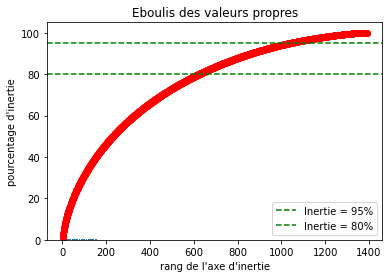

In [16]:
display_scree_plot(pca)

##### A lecture du graphique de l'éboulis des valeurs propres de notre jeu de données X, nous devons réduire le nombre des features à environ 950 features au lieu des 1 411 features obtenues après la première création des Bag-of-Words :

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2) en réglant max_features à 950 features.  

In [17]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2), #extract unigrams and bigrams
    max_features = 950
)
X = vectorizer.fit_transform(df.question_lemtokcl) #tfidf

In [18]:
vectorizer.get_feature_names() #visualisation des Bags-of-Words

['able',
 'accept',
 'access',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'address',
 'admin',
 'advance',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'already',
 'also',
 'also try',
 'always',
 'amount',
 'android',
 'angular',
 'animation',
 'answer',
 'apache',
 'api',
 'app',
 'appear',
 'append',
 'application',
 'apply',
 'appreciate',
 'approach',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'assume',
 'async',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authentication',
 'author',
 'auto',
 'automatically',
 'available',
 'avoid',
 'await',
 'axis',
 'back',
 'background',
 'background color',
 'bad',
 'bar',
 'base',
 'bash',
 'basic',
 'basically',
 'batch',
 'become',
 'begin',
 'behavior',
 'big',
 'bin',
 'binary',
 'bind',
 'bit',
 'black',
 'blank',
 'block',
 'blo

In [19]:
print("Shape of X : {}".format(X.shape)) #print the shape of X

Shape of X : (35809, 950)


In [20]:
# Materialize the sparse data
data_dense = X.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.4771235105552702 %


###### Encodage des  valeurs de la variable cible `tag_tok` : 

In [21]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.tag_tok)

In [22]:
print("Shape of y: {}".format(y.shape))

Shape of y: (35809, 8519)


###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible :

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (25066, 950)
X_test shape : (10743, 950)
y_train shape : (25066, 8519)
y_test shape : (10743, 8519)


In [24]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Méthode du LDA :
Dans le domaine du traitement automatique des langues, l’allocation de Dirichlet latente (de l’anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.
Pour chaque mot `w` de chaque document `d`, on calcule deux quantités pour chaque thème `t` : 

`p(t|d)` : la probabilité que le document `d` soit assigné au thème `t`.
`p(w|d)` : la probabilité que le thème `t` dans le corpus soit assigné au mot `w`.
On choisit alors le nouveau thème t avec la probabilité `p(t|d)` X `p(w|d)`. Ceci correspond à la probabilité que le thème `t` génère le mot `w` dans le document `d`.

En répétant les étapes précédentes un grand nombre de fois, les assignations se stabilisent. On obtient le mélange de thème présent dans chaque document en comptant chaque représentation d’un thème (assigné aux mots du document). On obtient les mots associés à chaque thème en comptant les mots qui y sont associés dans le corpus.

In [25]:
dict={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    perp=lda.perplexity(X)
    dict[i]=perp

In [26]:
dict

{2: 845.7887647811971,
 6: 1167.232659666541,
 10: 1371.199072488632,
 14: 1529.4122521718848}

In [27]:
dict2={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    scor=lda.score(X)
    dict2[i]=scor

In [28]:
dict2

{2: -1023436.9177883831,
 6: -1075682.5601994223,
 10: -1100587.5869468104,
 14: -1119065.2854135376}

In [29]:
lda =  LDA(n_components = 10) #model construction with 10 topics wanted

In [30]:
lda.fit(X) #model compilation

LatentDirichletAllocation()

In [31]:
lda.perplexity(X) #calculate of the model's perplexity

1360.2565303212295

In [32]:
lda.score(X) #calculate of the model's score

-1100036.734935357

In [33]:
pyLDAvis.sklearn.prepare(lda, X, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.015113  0.087148       1        1  13.648956
0      0.021702  0.129212       2        1  12.934501
7      0.005369 -0.043550       3        1  11.896104
2     -0.037484 -0.028523       4        1  11.268273
6      0.039876  0.103095       5        1  10.252869
1      0.072111 -0.058674       6        1   9.662257
3     -0.197378  0.000787       7        1   9.657552
5     -0.087919 -0.065894       8        1   7.986953
9      0.061613 -0.060607       9        1   6.543789
8      0.106996 -0.062994      10        1   6.148745, topic_info=        Term        Freq        Total Category  logprob  loglift
245      div  500.000000   500.000000  Default  30.0000  30.0000
660   public  550.000000   550.000000  Default  29.0000  29.0000
136    class  877.000000   877.000000  Default  28.0000  28.0000
28   android  389.000000   389.000000  Default  27.0000  27.0000
432      int  552.000000   552.000000  Default  26.0000  26.0000
..       ...         ...          ...      ...      ...      ...
796   static   60.058406   220.671435  Topic10  -5.0504   1.4876
660   public   79.024833   550.121475  Topic10  -4.7759   0.8485
892      use   82.434539  1305.513189  Topic10  -4.7337   0.0266
291    error   71.419178   707.837499  Topic10  -4.8771   0.4953
144     code   68.068132   806.571178  Topic10  -4.9252   0.3166

[570 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6         1  0.130344  action
6         2  0.108620  action
6         3  0.032586  action
6         4  0.391033  action
6         5  0.032586  action
...     ...       ...     ...
948       5  0.030736    year
948       6  0.015368    year
948       7  0.007684    year
948       8  0.053787    year
948       9  0.007684    year

[3573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 8, 3, 7, 2, 4, 6, 10, 9])

In [34]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(X)

print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
use page user good like http com web way url

Topic #1:
form function post input value type var user datum html

Topic #2:
view android button self event click control layout window text

Topic #3:
name column table value row model user datum field select

Topic #4:
date table sql query datum time database select value row

Topic #5:
function thread int std return use call char error foo

Topic #6:
string public class int array new list return object method

Topic #7:
project file use java run app error version build application

Topic #8:
div image color width class css height text style font

Topic #9:
file server use command path connection directory script run folder


#### Utilisation d'une méthode de "Fast LDA" :
- utilisation de LdaMulticore de la bibliothèque Gensim.

#### a. avec la variable `question_lemtokcl` sans preprocessing :

In [35]:
id2word = corpora.Dictionary(df.question_lemtokcl)

texts = df.question_lemtokcl
corpus = [id2word.doc2bow(text) for text in texts]

In [36]:
dict={}
for i in  np.arange(4,14,1) :
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.question_lemtokcl, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    dict[i]=coherence_lda
    print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3982900949849535
Coherence Score:  0.44074291683212297
Coherence Score:  0.46369964524865587
Coherence Score:  0.4914932328248459
Coherence Score:  0.495789944553356
Coherence Score:  0.4984469718479134
Coherence Score:  0.5034189174308418
Coherence Score:  0.5100702765834804
Coherence Score:  0.5092337293879724
Coherence Score:  0.47857357080503593


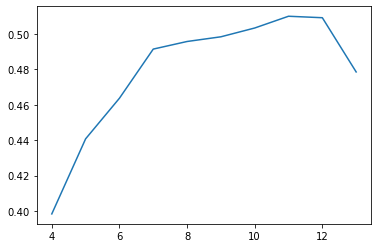

In [37]:
plt.plot(*zip(*sorted(dict.items())))
plt.show()

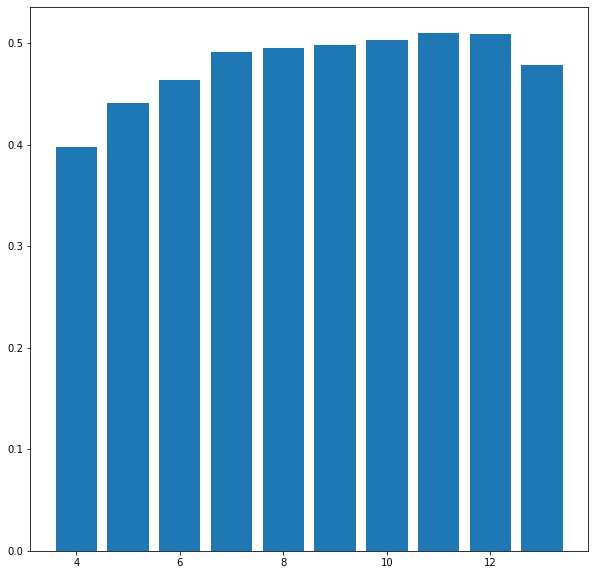

In [38]:
keys = dict.keys()
values = dict.values()

plt.figure(figsize=(10,10))
plt.bar(keys, values)
plt.show()

#### Modèle fastLDA avec 6 topics :

In [39]:
lda_model_6 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [40]:
vis_6 = pyLDAvis.gensim_models.prepare(lda_model_6, corpus, id2word)

In [41]:
vis_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.147523 -0.104986       1        1  20.352158
3     -0.004658 -0.036784       2        1  19.984497
4      0.122481  0.227542       3        1  17.712899
2     -0.148632  0.075907       4        1  15.979989
0      0.081348 -0.119156       5        1  15.825362
5     -0.198062 -0.042524       6        1  10.145095, topic_info=       Term          Freq         Total Category  logprob  loglift
38     file  21900.000000  21900.000000  Default  30.0000  30.0000
385     div  12657.000000  12657.000000  Default  29.0000  29.0000
31   string  16563.000000  16563.000000  Default  28.0000  28.0000
143     int  10725.000000  10725.000000  Default  27.0000  27.0000
84   public  10572.000000  10572.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
33      use   2298.290326  36566.400708   Topic6  -4.9643  -0.4788
232    code   1810.932043  20262.519186   Topic6  -5.2026  -0.1268
619    test   1401.530530   8916.598237   Topic6  -5.4589   0.4378
25     name   1484.238295  21007.189289   Topic6  -5.4016  -0.3618
216    work   1352.769137  16389.732859   Topic6  -5.4943  -0.2063

[516 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
352        2  0.993104  advantage
0          1  0.979389        age
0          2  0.019338        age
2764       2  0.028392       ajax
2764       3  0.970623       ajax
...      ...       ...        ...
9          1  0.876947       year
9          2  0.122000       year
9          4  0.000604       year
2946       6  0.996440        yml
15237      4  0.997563    youtube

[1424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1, 6])

#### Modèle fastLDA avec 10 topics :

In [42]:
lda_model_10 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [43]:
vis_10 = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, id2word)

In [44]:
vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.084719 -0.052305       1        1  17.520357
4      0.005733 -0.019324       2        1  13.917871
0     -0.040720  0.059526       3        1  13.589743
1     -0.101524  0.073308       4        1  12.967811
2     -0.003407 -0.160096       5        1  12.570889
9     -0.089720 -0.014610       6        1   8.761195
8     -0.057959  0.107450       7        1   8.377489
7     -0.105593  0.111386       8        1   6.777411
3      0.108358 -0.232035       9        1   3.211298
5      0.369551  0.126699      10        1   2.305936, topic_info=        Term          Freq         Total Category  logprob  loglift
38      file  23322.000000  23322.000000  Default  30.0000  30.0000
3619    self   7076.000000   7076.000000  Default  29.0000  29.0000
385      div  13427.000000  13427.000000  Default  28.0000  28.0000
143      int  11876.000000  11876.000000  Default  27.0000  27.0000
31    string  18468.000000  18468.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
162   return    574.484275  16972.045005  Topic10  -4.8693   0.3838
232     code    256.462057  21587.616565  Topic10  -5.6758  -0.6632
231    class    248.917246  22953.214017  Topic10  -5.7056  -0.7544
188    error    245.885965  17262.769915  Topic10  -5.7179  -0.4818
1251  import    233.035916   8785.434962  Topic10  -5.7715   0.1400

[776 rows x 6 columns], token_table=       Topic      Freq Term
term                       
21693      1  0.987527  adb
9883       7  0.997730  aes
7755       9  0.994428   af
0          2  0.000995  age
0          8  0.552362  age
...      ...       ...  ...
3957       1  0.002031  zip
3957       5  0.064992  zip
3957       6  0.026403  zip
3957       7  0.024372  zip
3957       8  0.879425  zip

[2643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 1, 2, 3, 10, 9, 8, 4, 6])

### Méthodes Supervisées :

In [45]:
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
per = Perceptron()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
svc = LinearSVC()
cmp = ComplementNB()

#### Méthode One VS Rest Classifier :

##### Modèle SGD Classifier avec la méthode One VS Rest Classifier :

In [46]:
start0 = time.process_time()

'\nimport time\nstart = time.process_time()\n'

In [47]:
clfsgd = OneVsRestClassifier(sgd)
clfsgd.fit(X_train, y_train)
y_pred_sgd = clfsgd.predict(X_test)   

In [48]:
end0 = time.process_time()
time0 = end0 - start0
print('Run Time :', time0)

"\nend = time.process_time()\ntime = end - start\nprint('Run Time :', time)\n"

In [49]:
sgd_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_sgd)
sgd_1vsrest_f1_score = metrics.f1_score(y_pred_sgd, y_test, average='weighted')
sgd_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_precison = metrics.precision_score(y_test, y_pred_sgd, average='weighted')

,Modèle,Accuracy,F1,Jaccard,Recall,Precision
<-->,SGDClass_1VsRestClass,0.024481,0.582133,0.147308,0.159737,0.342398


In [62]:
metrics_sgd_1vsrclass = metric_model('SGDClass_1VsRestClass', y_test, y_pred_sgd)
metrics_sgd_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
SGDClass_1VsRestClass,0.024481,0.582133,0.147308,0.159737,0.342398


##### Modèle Logistic Régression avec la méthode One VS Rest Classifier :

In [50]:
start1 = time.process_time()

'\nimport time\nstart1 = time.process_time()\n'

In [51]:
clflr = OneVsRestClassifier(lr)
clflr.fit(X_train, y_train)
y_pred_lr = clflr.predict(X_test) 

In [52]:
end1 = time.process_time()
time1 = end1 - start1
print('Run Time :', time1)

"\nend1 = time.process_time()\ntime1 = end1 - start1\nprint('Run Time :', time1)\n"

In [53]:
lr_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_lr)
lr_1vsrest_f1_score = metrics.f1_score(y_pred_lr, y_test, average='weighted')
lr_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_precison = metrics.precision_score(y_test, y_pred_lr, average='weighted')

,Modèle,Accuracy,F1,Jaccard,Recall,Precision
<-->,LogisticReg_1VsRestClass,0.026994,0.519371,0.151626,0.163532,0.410137


In [63]:
metrics_lr_1vsrclass = metric_model('LogisticReg_1VsRestClass', y_test, y_pred_lr)
metrics_lr_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
LogisticReg_1VsRestClass,0.026994,0.519371,0.151626,0.163532,0.410137


##### Modèle  Multinomial NB avec la méthode One VS Rest Classifier :

In [54]:
clfmn = OneVsRestClassifier(mn)
clfmn.fit(X_train, y_train)
y_pred_mn = clfmn.predict(X_test) 

In [55]:
mn_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_mn)
mn_1vsrest_f1_score = metrics.f1_score(y_pred_mn, y_test, average='weighted')
mn_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_precison = metrics.precision_score(y_test, y_pred_mn, average='weighted')

,Modèle,Accuracy,F1,Jaccard,Recall,Precision
<-->,MultinomialNB _1VsRestClass,0.008657,0.380516,0.057158,0.062486,0.294668


In [64]:
metrics_mn_1vsrclass = metric_model('MultinomialNB _1VsRestClass', y_test, y_pred_mn)
metrics_mn_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
MultinomialNB _1VsRestClass,0.008657,0.380516,0.057158,0.062486,0.294668


##### Modèle  Perceptron avec la méthode One VS Rest Classifier :

In [56]:
clfper = OneVsRestClassifier(per)
clfper.fit(X_train, y_train)
y_pred_per = clfper.predict(X_test) 

In [57]:
per_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_per)
per_1vsrest_f1_score = metrics.f1_score(y_pred_per, y_test, average='weighted')
per_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_per, average='weighted')
per_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_per, average='weighted')
per_1vsrest_precison = metrics.precision_score(y_test, y_pred_per, average='weighted')

,Modèle,Accuracy,F1,Jaccard,Recall,Precision
<-->,Perceptron_1VsRestClass,0.012752,0.222526,0.177246,0.270100,0.278960


In [65]:
metrics_per_1vsrclass = metric_model('Perceptron_1VsRestClass', y_test, y_pred_per)
metrics_per_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
Perceptron_1VsRestClass,0.012752,0.222526,0.177246,0.270100,0.278960


##### Modèle  Linear SVC avec la méthode One VS Rest Classifier :

In [58]:
clfsvc = OneVsRestClassifier(svc)
clfsvc.fit(X_train, y_train)
y_pred_svc = clfsvc.predict(X_test)

In [59]:
svc_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_1vsrest_f1_score = metrics.f1_score(y_pred_svc, y_test, average='weighted')
svc_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_precison = metrics.precision_score(y_test, y_pred_svc, average='weighted')

,Modèle,Accuracy,F1,Jaccard,Recall,Precision
<-->,LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989


In [66]:
metrics_svc_1vsrclass = metric_model('LinearSVC_1VsRestClass', y_test, y_pred_svc)
metrics_svc_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989


#### Confrontation des métriques des modèles avec la méthode One VS Rest Classifier :

In [67]:
frames = [metrics_sgd_1vsrclass, metrics_lr_1vsrclass, metrics_mn_1vsrclass, metrics_per_1vsrclass, metrics_svc_1vsrclass]
tab_metrics_1vsrclass = pd.concat(frames)
tab_metrics_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Jaccard,Recall,Precision
SGDClass_1VsRestClass,0.024481,0.582133,0.147308,0.159737,0.342398
LogisticReg_1VsRestClass,0.026994,0.519371,0.151626,0.163532,0.410137
MultinomialNB _1VsRestClass,0.008657,0.380516,0.057158,0.062486,0.294668
Perceptron_1VsRestClass,0.012752,0.222526,0.177246,0.270100,0.278960
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989


#### Sélection du meilleur modèle et optimisation par Grid Search du meilleur modèle :

In [85]:
svc.get_params()

{'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': True,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__loss': 'squared_hinge',
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator': LinearSVC(),
 'n_jobs': None}

In [73]:
param_grid = {'estimator__C':[0.1,0.5,1,1.5,2,10,50]
              }

In [78]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 3, verbose=10,
                                      scoring=make_scorer(metrics.jaccard_score,greater_is_better=True))

In [79]:
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__C=1..............................................
[CV 1/5; 1/4] END ............................estimator__C=1; total time= 2.4min
[CV 2/5; 1/4] START estimator__C=1..............................................
[CV 2/5; 1/4] END ............................estimator__C=1; total time= 2.4min
[CV 3/5; 1/4] START estimator__C=1..............................................
[CV 3/5; 1/4] END ............................estimator__C=1; total time= 2.7min
[CV 4/5; 1/4] START estimator__C=1..............................................
[CV 4/5; 1/4] END ............................estimator__C=1; total time= 2.4min
[CV 5/5; 1/4] START estimator__C=1..............................................
[CV 5/5; 1/4] END ............................estimator__C=1; total time= 2.5min
[CV 1/5; 2/4] START estimator__C=10.............................................
[CV 1/5; 2/4] END ...........................esti

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 10, 100, 1000]},
             scoring=make_scorer(jaccard_score), verbose=10)

In [80]:
CV_svc.best_params_

{'estimator__C': 1}

In [81]:
best_model = CV_svc.best_estimator_

In [83]:
y_pred_svc_bestmodel = best_model.predict(X_test)

In [84]:
metrics_svc_bestmodel = metric_model('LinearSVC_1VsRestClass', y_test, y_pred_svc_bestmodel)
metrics_svc_bestmodel.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Jaccard,Recall,Precision
LinearSVC_1VsRestClass,0.039281,0.554768,0.198556,0.221187,0.447989


#### Export du meilleur modèle optimisé et des préprocessings :

In [108]:
joblib.dump(best_model,'best_model.pkl')

['best_model.pkl']

In [109]:
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [110]:
joblib.dump(mlb,'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']

#### Méthode Classifier Chain:

##### Modèle  Multinomial NB avec la méthode Classifier Chain :

In [ ]:
"""
chnmn = ClassifierChain(mn, order='random', random_state=0)
chnmn.fit(X_train, y_train)
y_pred_chnmn = chnmn.predict(X_test)
"""

In [ ]:
"""
mn_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnmn)
mn_chn_f1_score = metrics.f1_score(y_pred_chnmn, y_test, average='weighted')
mn_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_recallsc = metrics.recall_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_precison = metrics.precision_score(y_test, y_pred_chnmn, average='weighted')
metrics_mn_chn = metric_model('MultinomialNB_ClassChain', y_test, y_pred_chnmn)
metrics_mn_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

##### Modèle  Complement NB avec la méthode Classifier Chain :

In [ ]:
"""
chncmp = ClassifierChain(cmp, order='random', random_state=0)
chncmp.fit(X_train, y_train)
y_pred_chncmp = chncmp.predict(X_test)
"""

In [ ]:
"""
cmp_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chncmp)
cmp_chn_f1_score = metrics.f1_score(y_pred_chncmp, y_test, average='weighted')
cmp_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_recallsc = metrics.recall_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_precison = metrics.precision_score(y_test, y_pred_chncmp, average='weighted')
metrics_cmp_chn = metric_model('ComplementNB_ClassChain', y_test, y_pred_chncmp)
metrics_cmp_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

##### Modèle  Random Forest Classifier avec la méthode Classifier Chain :

In [ ]:
"""
chnrfc = ClassifierChain(rfc, order='random', random_state=0)
chnrfc.fit(X_train, y_train)
y_pred_chnrfc = chnrfc.predict(X_test)
"""

In [ ]:
"""
rfc_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnrfc)
rfc_chn_f1_score = metrics.f1_score(y_pred_chnrfc, y_test, average='weighted')
rfc_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnrfc, average='weighted')
rfc_chn_recallsc = metrics.recall_score(y_test, y_pred_chnrfc, average='weighted')
rfc_chn_precison = metrics.precision_score(y_test, y_pred_chnrfc, average='weighted')
metrics_rfc_chn = metric_model('RandomForest_ClassChain', y_test, y_pred_chnrfc)
metrics_rfc_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
"""

In [ ]:
end_dr1 = time.process_time()
time_dr1 = end_dr1 - start_dr1
print('Run Time :', time_dr1)